0.25998


(array([7.58283478e-03, 2.88147722e-02, 1.04643120e-01, 1.89570870e-01,
        1.95637137e-01, 2.48716981e-01, 2.69190635e-01, 3.19995628e-01,
        3.10137943e-01, 2.69190635e-01, 2.36584445e-01, 1.88812586e-01,
        2.39617579e-01, 3.02555108e-01, 4.28430165e-01, 5.17907616e-01,
        5.49755522e-01, 7.32501840e-01, 7.96955936e-01, 7.87856534e-01,
        8.22737574e-01, 8.24254141e-01, 7.49942360e-01, 6.80938564e-01,
        5.55063506e-01, 4.21605614e-01, 3.13171077e-01, 1.79713184e-01,
        1.35732743e-01, 7.58283478e-02, 4.32221583e-02, 4.32221583e-02,
        3.63976070e-02, 2.65399217e-02, 1.89570870e-02, 1.13742522e-02,
        9.85768522e-03, 7.58283478e-03, 2.27485044e-03, 3.79141739e-03,
        3.03313391e-03, 1.51656696e-03, 1.51656696e-03, 7.58283478e-04,
        7.58283478e-04, 7.58283478e-04, 0.00000000e+00, 0.00000000e+00,
        7.58283478e-04, 7.58283478e-04]),
 array([2.00750751, 2.093003  , 2.1784985 , 2.26399399, 2.34948949,
        2.43498498, 2.5204

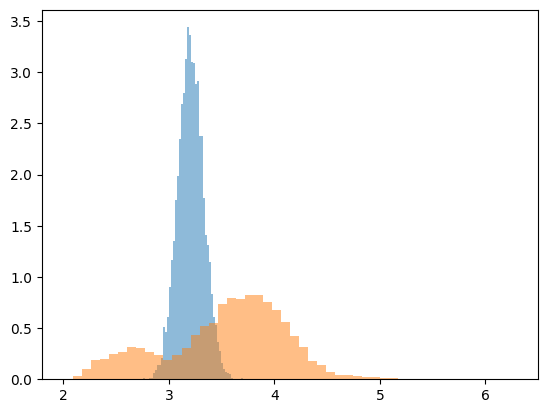

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import statistics

# generate toy data for TOV
def gen_TOV_samples(mean, std_dev, n_samples):
    samples = np.random.normal(loc=mean, scale=std_dev, size=n_samples)
    return samples

# use Monte carlo methods to compute the new masses with rotation
def gen_ROT_samples(TOV_samples,R_mean,R_error):
    mR_samples = []
    for i in range(len(TOV_samples)):
        mR_samples.append(TOV_samples[i]*np.random.normal(loc=R_mean,scale=R_error,size=1)[0])
    return mR_samples

# calculates a random integer from 0 to N
def random_int(upper_limit):
    return random.randint(0,upper_limit)

# Computes the probability of that the observed measurement is described by the theoretical value
# using Monte carlo sampling
def MC_prob(the_samples, exp_samples, nruns):
    # Monte Carlo code to compute probability
    count = 0
    for i in range(nruns):
        rTh = random_int(len(the_samples)-1)
        rEx = random_int(len(exp_samples)-1)
        mTh = the_samples[rTh]
        mEx = exp_samples[rEx]
        if (mTh > mEx):
            count = count + 1

    prob = count/nruns
    return prob

# Using the probability function, obtain a sampling array of the experimental measurement from LIGO
# uses accept/reject sampling
def gen_exp_samples(file,npoints):
    prob_func = np.loadtxt(file)
    size = len(prob_func)

    exp_masses = []
    for i in range(npoints):
        index = random_int(size-1)
        r = random.random()
        p = prob_func[index][1]
        mass = prob_func[index][0]
        if (r<p):
            exp_masses.append(mass)
    return exp_masses

# define number of samples in samplings
N_samples = 100000

# define the mass increase factors with rotation
rot_factor = 1.260
rot_error = 0.04

# import TOV masses
mTOV_samples = np.loadtxt("MCMC_complete_26.txt")[:,17]
#mTOV_samples = gen_TOV_samples(2.7,0.1,100000)

# generate maximum masses with rotation
mMAX_samples = gen_ROT_samples(mTOV_samples,rot_factor,rot_error)

# generate EXP masses
mEXP_samples = gen_exp_samples("mass_ls_data.txt",N_samples)

# compute probability
prob = MC_prob(mMAX_samples,mEXP_samples,N_samples)
print(prob)

#s2 = rot_factor**2 * 0.1**2 + 2.7**2 * rot_error**2
#test = gen_TOV_samples(2.7*rot_factor,np.sqrt(s2),100000)

plt.hist(mMAX_samples,bins=50,density=True,alpha=0.5)
plt.hist(mEXP_samples,bins=50,density=True,alpha=0.5)

In [2]:
import statistics
import numpy as np

samples = np.loadtxt("MCMC_complete_26.txt")
# Get mean values and uncertainties for the bulk properties

for i in range(7):
    print(statistics.mean(samples[:,i]))


-16.26995407
1.312671339
0.5843732534
244.3419784
33.23473693
45.74291391
0.00356977081667
0.0004102762846
